# 02. Neural Network classification with PyTorch

## 1. Make classification data

In [724]:
import sklearn

In [725]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles :)
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [726]:
len(X), len(y)

(1000, 1000)

In [727]:
print(f"First 5 samples:\n {X[:5]}\n")
print(f"First 5 labels:\n {y[:5]}")

First 5 samples:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 labels:
 [1 1 1 1 0]


In [728]:
# Make Pandas dataframe
import pandas as pd
circles = pd.DataFrame({'X1': X[:,0], # just a dictionary in a df
                        'X2': X[:,1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


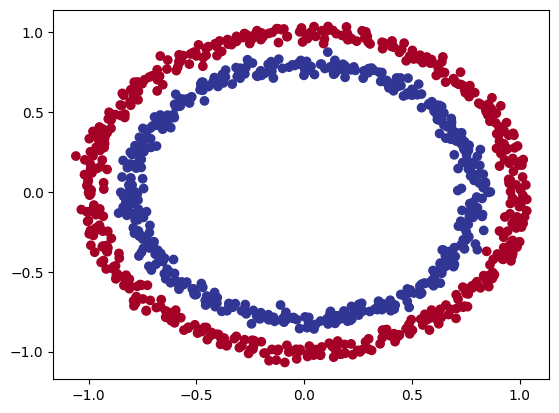

In [729]:
# Let's visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and output

In [730]:
X.shape, y.shape

((1000, 2), (1000,))

In [731]:
X_sample = X[0]
y_sample = y[0]
print(f"A sample of X: {X_sample}, shape: {X_sample.shape}")
print(f"A sample of y: {y_sample}, shape: {y_sample.shape}")

A sample of X: [0.75424625 0.23148074], shape: (2,)
A sample of y: 1, shape: ()


### 1.2 Data into tensors, train-test split

In [732]:
import torch
torch.__version__

'2.6.0+cu124'

In [733]:
# Into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [734]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [735]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [736]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a classification model

Steps:
1. Setup device agnostic code
2. Construct a model (with `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and testing loop

In [737]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's create a model which:
1. Subclasses `nn.Module` (as almost all PyTorch models)
2. Create 2 `nn.Linear()` layers capable of handling our data
3. Defines a `forward()` method
4. Instatiate an instance of our model class and send it to the target device

In [738]:
# 1. Constructor

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
      return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [739]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [740]:
# Let's do the model easier with nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [741]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3016, -0.1420],
                      [-0.1661, -0.6698],
                      [ 0.2811,  0.5823],
                      [-0.3900,  0.1906],
                      [-0.0820, -0.0258]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0412,  0.6128,  0.0947, -0.4474, -0.2544], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2185,  0.1396,  0.0087, -0.0590, -0.1740]], device='cuda:0')),
             ('1.bias', tensor([-0.1587], device='cuda:0'))])

In [742]:
# Make some predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"First 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of test samples: 200, shape: torch.Size([200, 2])
Length of predictions: 200, shape: torch.Size([200, 1])
First 10 predictions:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]], device='cuda:0')
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [743]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

For classification, binary cross entropy or categorical cross entropy are usual.

In [744]:
# Setup the loss function

#loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid already before
loss_fn = nn.BCEWithLogitsLoss() # this is a built-in sigmoid activation function, better option

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [745]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train a model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Raw logits -> prediction probabilities -> prediction labels

Our model outputs are raw **logits**. Thus, we pass them to an activation function (e.g. sigmoid or softmax) to get **prediction probabilites**. Then, we convert those to **prediction labels**.

In [746]:
# View the first 5 outputs
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0604],
        [-0.1147],
        [ 0.0817],
        [-0.1006],
        [ 0.0813]], device='cuda:0')

In [747]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [748]:
# Let's use sigmoid
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4849],
        [0.4714],
        [0.5204],
        [0.4749],
        [0.5203]], device='cuda:0')

For the prediction probability values, we need a range-style rounding:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [749]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training loop

In [750]:
torch.cuda.manual_seed(42)

epochs = 1000

# Data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Training and testing loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # Calculate loss / accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze(dim=1)
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss / accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_preds)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69487 | Acc: 49.00% | Test Loss: 0.69098 | Test Acc: 54.00%
Epoch: 10 | Loss: 0.69450 | Acc: 48.62% | Test Loss: 0.69119 | Test Acc: 54.00%
Epoch: 20 | Loss: 0.69422 | Acc: 48.88% | Test Loss: 0.69140 | Test Acc: 53.00%
Epoch: 30 | Loss: 0.69400 | Acc: 49.00% | Test Loss: 0.69161 | Test Acc: 53.00%
Epoch: 40 | Loss: 0.69382 | Acc: 48.38% | Test Loss: 0.69181 | Test Acc: 52.50%
Epoch: 50 | Loss: 0.69368 | Acc: 48.38% | Test Loss: 0.69201 | Test Acc: 53.00%
Epoch: 60 | Loss: 0.69356 | Acc: 48.25% | Test Loss: 0.69219 | Test Acc: 52.50%
Epoch: 70 | Loss: 0.69346 | Acc: 48.00% | Test Loss: 0.69237 | Test Acc: 52.50%
Epoch: 80 | Loss: 0.69338 | Acc: 47.50% | Test Loss: 0.69253 | Test Acc: 50.50%
Epoch: 90 | Loss: 0.69331 | Acc: 47.25% | Test Loss: 0.69269 | Test Acc: 51.50%
Epoch: 100 | Loss: 0.69326 | Acc: 46.75% | Test Loss: 0.69284 | Test Acc: 49.00%
Epoch: 110 | Loss: 0.69321 | Acc: 45.12% | Test Loss: 0.69298 | Test Acc: 46.50%
Epoch: 120 | Loss: 0.69317 | Acc: 43.50

## 4. Make predictions and evaluate the model

Looks like a bad model. Let's see.

We import `helper_functions.py` and use `plot_decision_boundary()`.

In [751]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


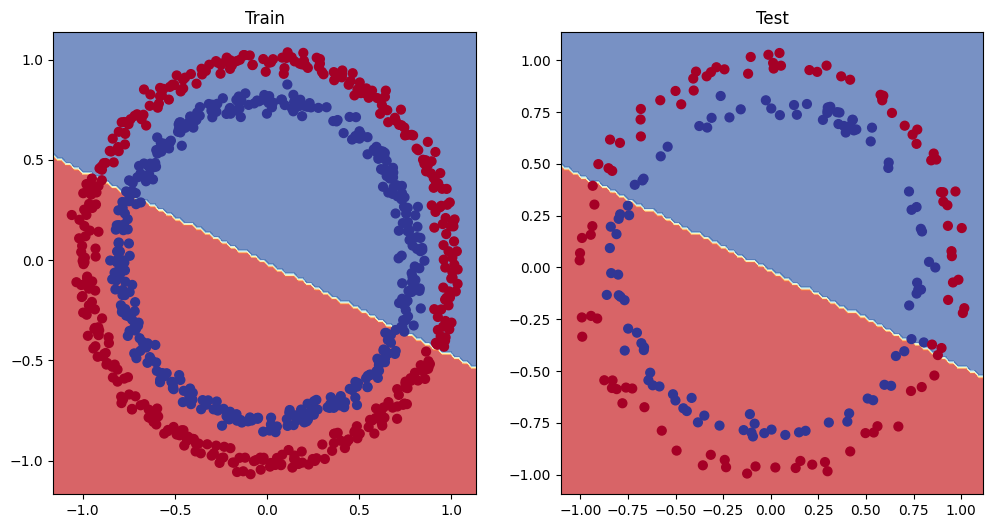

In [752]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more learning chances
* Add more hidden units - from 5 to 10 in our case for example
* Fit for longer
* Change the activation function
* Change the optimizer function
* Change the learning rate
* Change the loss function

So, changing the **hyperparameters**.

Let's try!

In [753]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer1(x)
    # z = self.layer2(z)
    # z = self.layer3(z)
    # return z
    return self.layer3(self.layer2(self.layer1(x))) # faster!

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [754]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [755]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits --> pred probs --> pred labels
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc}")


Epoch: 0 | Loss: 0.70069, Acc: 50.00% | Test Loss: 0.70262, Test Acc: 50.0
Epoch: 100 | Loss: 0.69303, Acc: 51.00% | Test Loss: 0.69502, Test Acc: 47.5
Epoch: 200 | Loss: 0.69300, Acc: 51.00% | Test Loss: 0.69486, Test Acc: 46.0
Epoch: 300 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69478, Test Acc: 47.0
Epoch: 400 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69473, Test Acc: 46.0
Epoch: 500 | Loss: 0.69298, Acc: 50.88% | Test Loss: 0.69471, Test Acc: 45.5
Epoch: 600 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69470, Test Acc: 45.5
Epoch: 700 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69469, Test Acc: 45.5
Epoch: 800 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69469, Test Acc: 46.0
Epoch: 900 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69468, Test Acc: 46.0


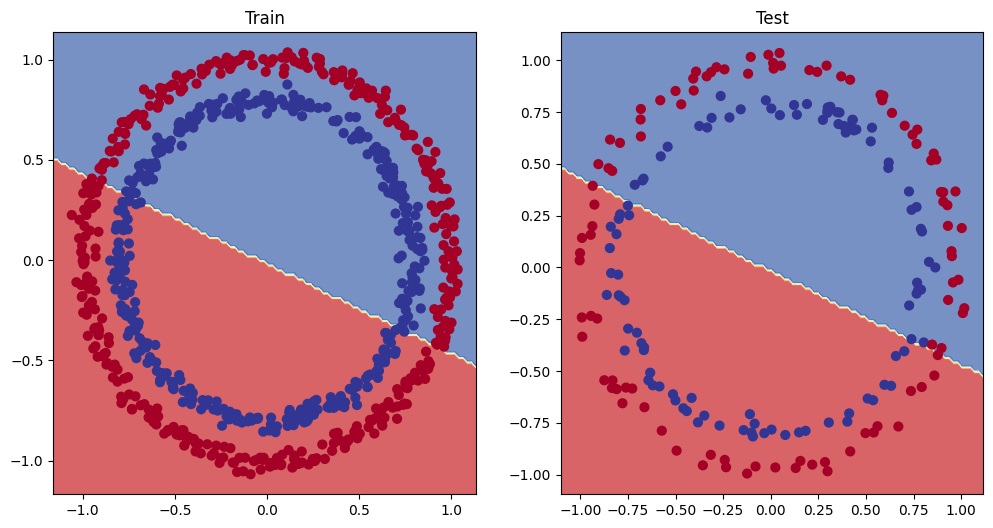

In [756]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

One way to troubleshoot a larger problem is to test out a smaller problem.

In [757]:
# Create data (as in notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression), len(y_regression))
X_regression[:5], y_regression[:5]

100 100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [758]:
# Train and test splits
train_split = int(0.8 * len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

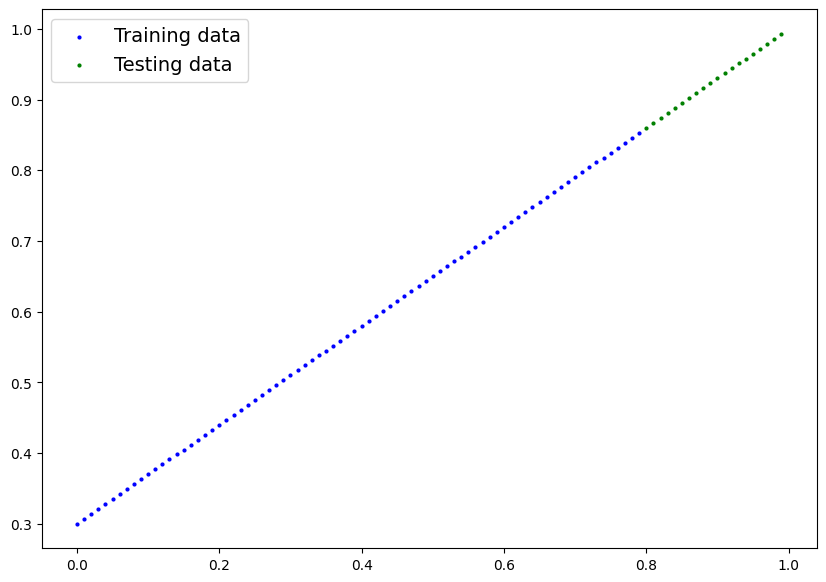

In [759]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg,
                 predictions=None)

### Adjusting `model_1` to fit a straight line

In [760]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [761]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [762]:
# Train + test
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  model_2.train()
  y_preds_reg = model_2(X_train_reg)
  loss = loss_fn(y_preds_reg, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_preds_reg = model_2(X_test_reg)
    test_loss = loss_fn(test_preds_reg, y_test_reg)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


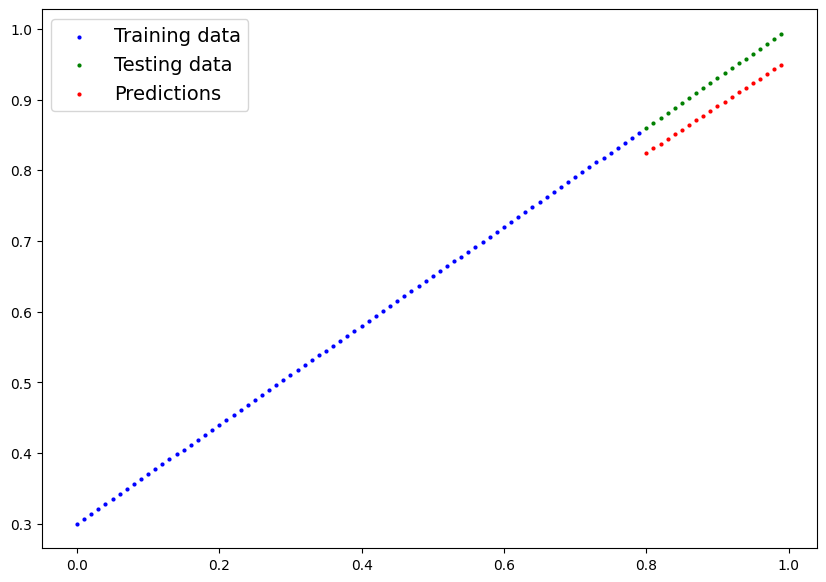

In [763]:
model_2.eval()

with torch.inference_mode():
  y_preds_reg = model_2(X_test_reg)

plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds_reg.cpu())


## 6. The missing piece: non-linearity

### 6.1 Creating non-linear data (again)

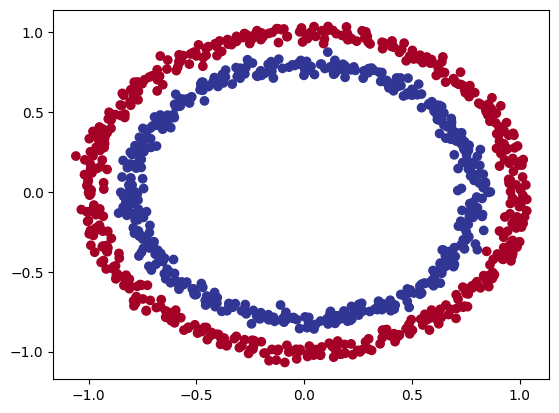

In [764]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [765]:
# Data into tensors
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building and training a non-linear model!

In [766]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=16)
    self.layer2 = nn.Linear(in_features=16, out_features=8)
    self.layer3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU() # a non-linear activation function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) # relu between layers!

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [767]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [768]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits --> pred probs --> pred labels
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70169, Acc: 50.00% | Test Loss: 0.70137, Test Acc: 50.00
Epoch: 100 | Loss: 0.69149, Acc: 55.00% | Test Loss: 0.69251, Test Acc: 48.00
Epoch: 200 | Loss: 0.68906, Acc: 60.75% | Test Loss: 0.69106, Test Acc: 54.50
Epoch: 300 | Loss: 0.68597, Acc: 55.62% | Test Loss: 0.68919, Test Acc: 51.00
Epoch: 400 | Loss: 0.68187, Acc: 56.00% | Test Loss: 0.68672, Test Acc: 51.50
Epoch: 500 | Loss: 0.67546, Acc: 56.25% | Test Loss: 0.68220, Test Acc: 52.50
Epoch: 600 | Loss: 0.66491, Acc: 61.38% | Test Loss: 0.67438, Test Acc: 53.00
Epoch: 700 | Loss: 0.64716, Acc: 73.88% | Test Loss: 0.65980, Test Acc: 70.00
Epoch: 800 | Loss: 0.61399, Acc: 90.75% | Test Loss: 0.63100, Test Acc: 88.00
Epoch: 900 | Loss: 0.55110, Acc: 98.50% | Test Loss: 0.57679, Test Acc: 96.50


In [769]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

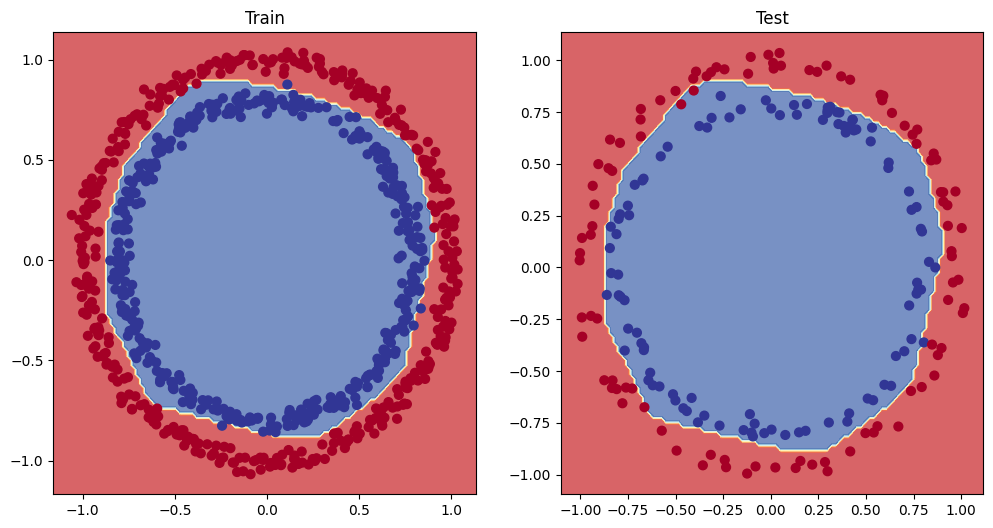

In [770]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [771]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [772]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

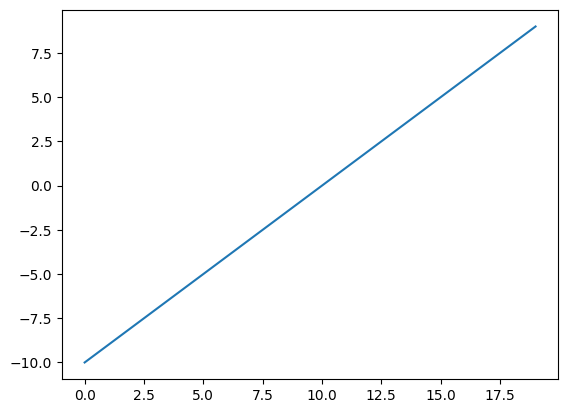

In [773]:
plt.plot(A);

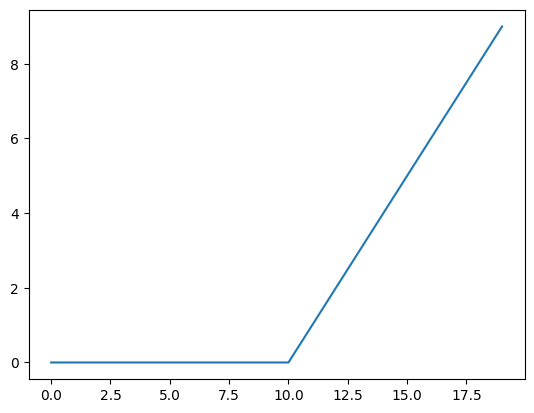

In [774]:
plt.plot(torch.relu(A));

In [775]:
def relu(x):
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

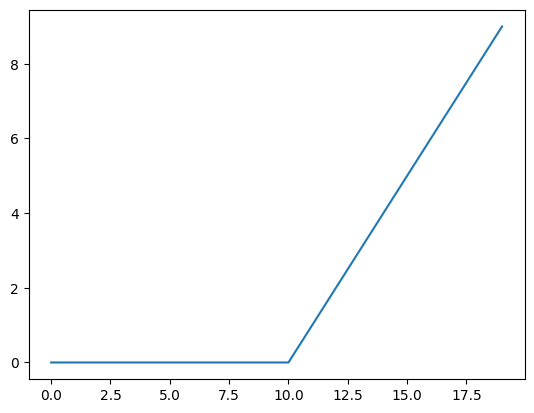

In [776]:
plt.plot(relu(A));

In [777]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

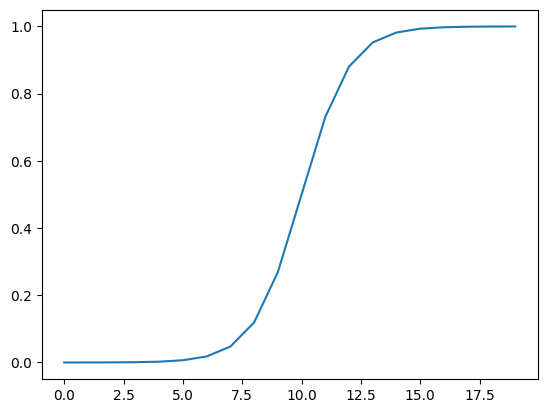

In [778]:
plt.plot(torch.sigmoid(A));

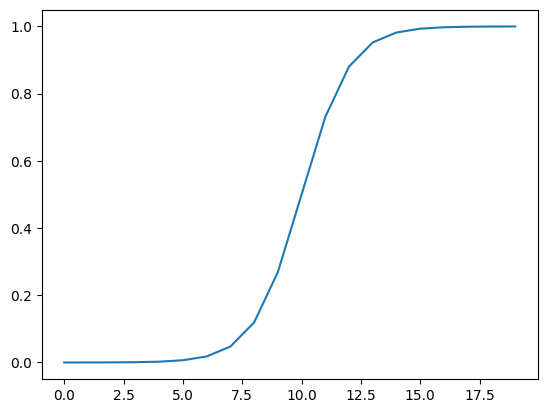

In [779]:
plt.plot(sigmoid(A));

## 8. Multi-class classification problem

* Binary classification - two classes
* Multi-class classification - more than two classes

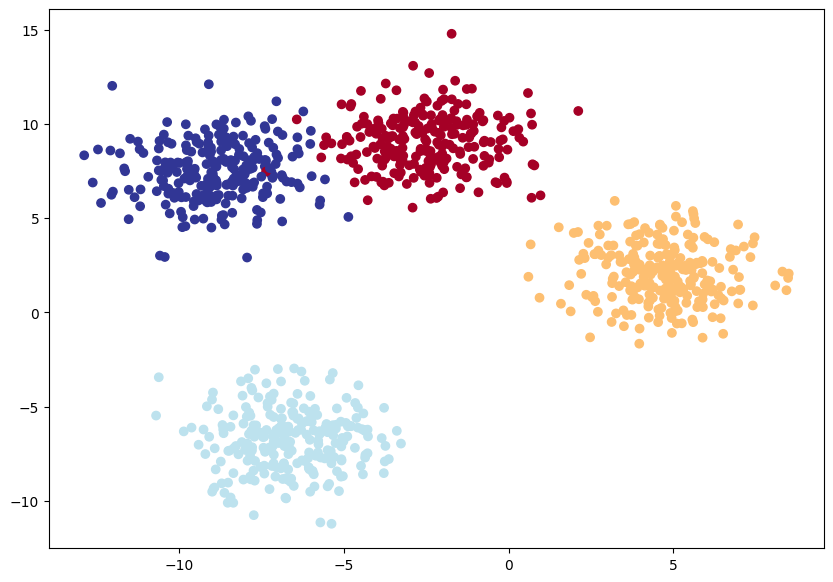

In [780]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Creating multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train and test splits
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.1 Let's build the model!

In [781]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [782]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features of the model.
      hidden_units (int, optional): Number of hidden layers of the model. Defaults to 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # note that nonlinearity is not a must with our data!
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [783]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                         lr=0.1)

In [784]:
# Let's do some predictions!
# Remember: logits --> pred probs --> pred labels

model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_train.to(device))
y_logits[:10]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]], device='cuda:0')

In [785]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:10], "\n\n", y_pred_probs[:10])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]], device='cuda:0') 

 tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190],
        [0.3611, 0.1419, 0.1719, 0.3251],
        [0.3580, 0.1286, 0.1668, 0.3466],
        [0.3124, 0.2956, 0.1708, 0.2212],
        [0.3271, 0.1498, 0.2140, 0.3091],
        [0.3501, 0.1372, 0.1806, 0.3321]], device='cuda:0')


In [786]:
# Let's get the (random) predictions!
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Finally, a training loop!

In [787]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50


In [788]:
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

y_logits

tensor([[ -0.6249,   5.9860,  -7.6323,  -8.4470],
        [ -2.1738,  -6.3750,  -3.7202,   3.1203],
        [ -3.4102,  -3.8958,   3.1567,  -2.6119],
        [ -1.1505,   4.1962,  -3.8472,  -4.8820],
        [  3.7548,  -1.3391,  -9.1422,  -6.9466],
        [ -2.8211,  -7.5767,  -4.2944,   3.7944],
        [ -3.0306,  -3.3328,   2.7955,  -2.1374],
        [  3.3761,  -4.0375,  -6.8987,  -3.5503],
        [ -4.3620,  -4.9904,   3.8123,  -3.3814],
        [  3.5012,  -3.0281,  -7.5401,  -4.7064],
        [  2.5349,  -4.8660,  -5.9197,  -2.1011],
        [ -1.1084,   7.2212,  -8.7214,  -9.5784],
        [  3.8244,  -2.2643,  -8.7786,  -6.1321],
        [  3.8924,  -3.9959,  -8.3434,  -4.6917],
        [  4.2013,  -3.7174,  -9.2818,  -5.5978],
        [ -1.1567,  -5.8345,  -4.0673,   2.0870],
        [ -2.3728,  -6.5535,  -3.6653,   3.2484],
        [ -2.4781,  -2.9919,   2.4828,  -1.7850],
        [ -1.5865,  -7.3585,  -5.2907,   2.7828],
        [ -2.8401,  -6.2987,  -2.3842,   2.8046],


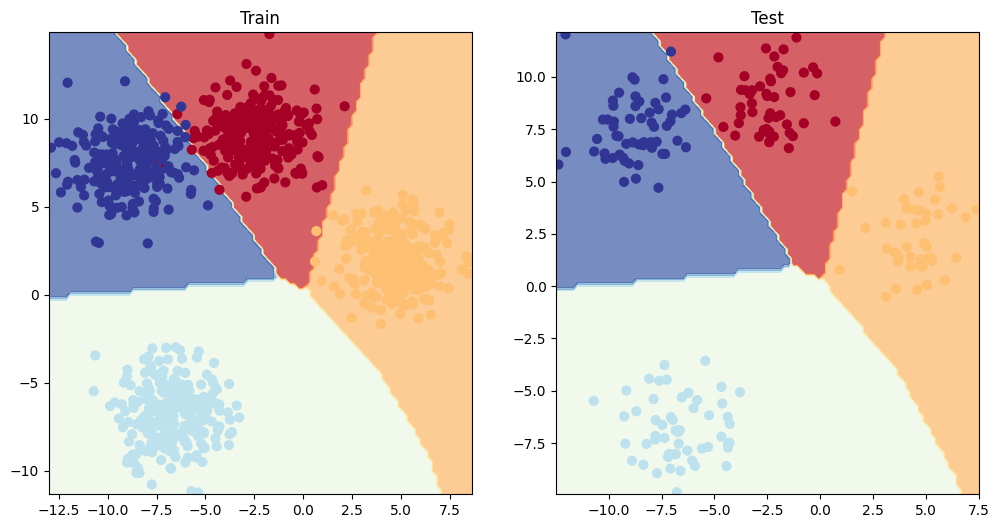

In [789]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob, y_blob)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics

* Accuracy - which percentage we get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [790]:
!pip install torchmetrics

In [791]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises :)

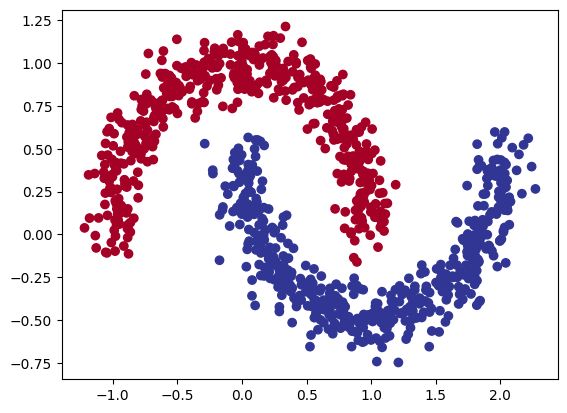

In [792]:
# Task 1
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

n_samples = 1000
random_state = 42

data = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)

X = data[0]
y = data[1]
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

len(X_train), len(X_test), len(y_train), len(y_test)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


In [793]:
class ModelEx1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layerStack = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    return self.layerStack(x)

model_ex1 = ModelEx1().to(device)
model_ex1

ModelEx1(
  (layerStack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [794]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_ex1.parameters(), lr=0.15)

In [795]:
epochs = 400

for epoch in range(epochs):
  model_ex1.train()
  y_logits = model_ex1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = torchmetrics_accuracy(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_ex1.eval()
  with torch.inference_mode():
    test_logits = model_ex1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = torchmetrics_accuracy(test_preds, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")



Epoch: 0 | Loss: 0.68712, Acc: 0.62 | Test Loss: 0.68437, Test Acc: 0.57
Epoch: 10 | Loss: 0.63652, Acc: 0.74 | Test Loss: 0.63772, Test Acc: 0.69
Epoch: 20 | Loss: 0.56804, Acc: 0.78 | Test Loss: 0.57372, Test Acc: 0.74
Epoch: 30 | Loss: 0.48362, Acc: 0.81 | Test Loss: 0.49351, Test Acc: 0.76
Epoch: 40 | Loss: 0.40377, Acc: 0.83 | Test Loss: 0.41371, Test Acc: 0.81
Epoch: 50 | Loss: 0.34819, Acc: 0.84 | Test Loss: 0.35609, Test Acc: 0.82
Epoch: 60 | Loss: 0.31512, Acc: 0.86 | Test Loss: 0.31975, Test Acc: 0.86
Epoch: 70 | Loss: 0.29364, Acc: 0.87 | Test Loss: 0.29491, Test Acc: 0.86
Epoch: 80 | Loss: 0.27909, Acc: 0.87 | Test Loss: 0.27751, Test Acc: 0.86
Epoch: 90 | Loss: 0.26858, Acc: 0.88 | Test Loss: 0.26531, Test Acc: 0.86
Epoch: 100 | Loss: 0.26115, Acc: 0.88 | Test Loss: 0.25657, Test Acc: 0.87
Epoch: 110 | Loss: 0.25513, Acc: 0.88 | Test Loss: 0.24976, Test Acc: 0.88
Epoch: 120 | Loss: 0.24976, Acc: 0.88 | Test Loss: 0.24406, Test Acc: 0.89
Epoch: 130 | Loss: 0.24460, Acc: 0.8

In [796]:
model_ex1.eval()
with torch.inference_mode():
  y_test_logits = model_ex1(X_test).squeeze()
  y_test_preds = torch.round(torch.sigmoid(y_test_logits))

In [797]:
X_test.shape, y_test.shape, y_test_preds.shape

(torch.Size([200, 2]), torch.Size([200]), torch.Size([200]))

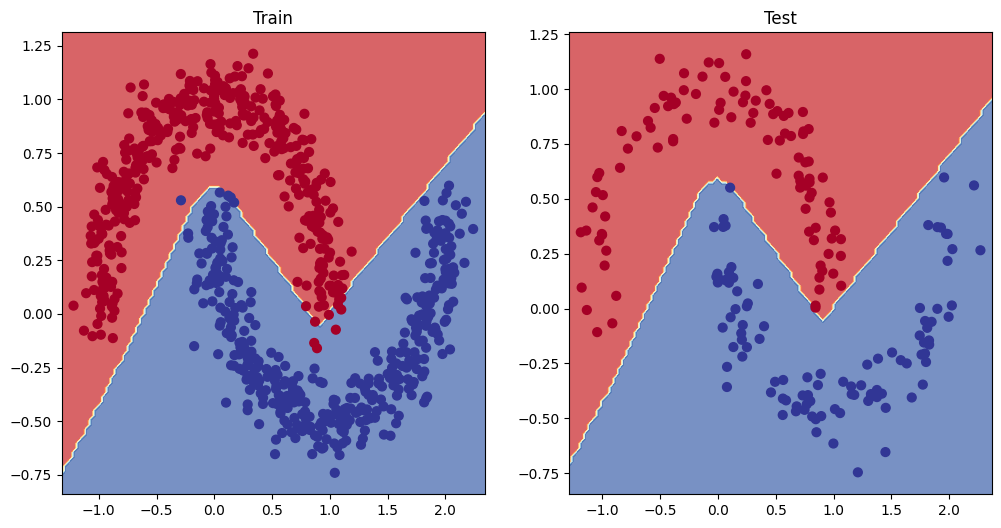

In [798]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_ex1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_ex1, X_test, y_test)


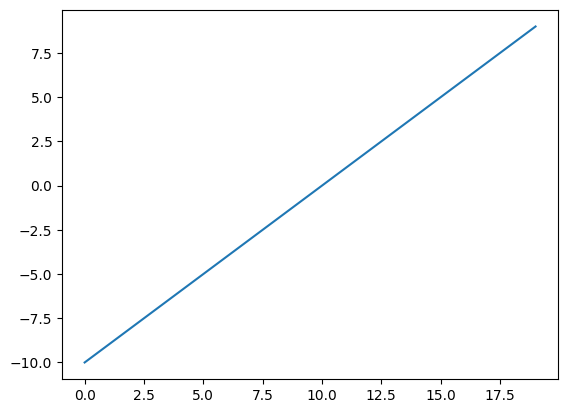

In [799]:
# 6.
X = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(X);

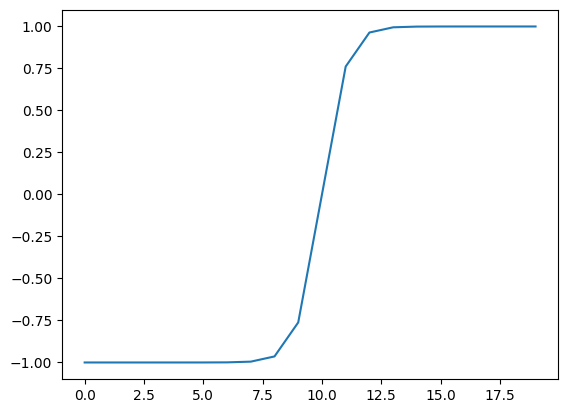

In [800]:
def tanh(x):
  return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

plt.plot(tanh(X));

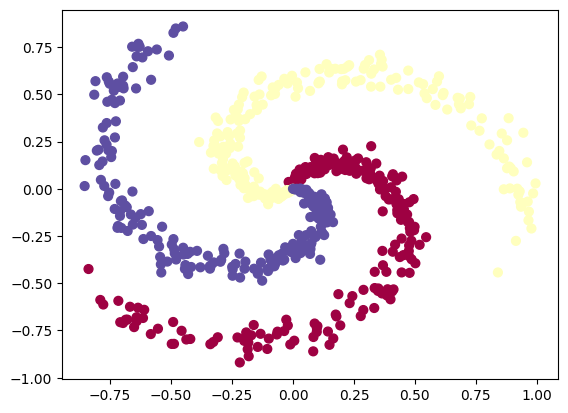

(torch.Size([480, 2]),
 torch.Size([480]),
 torch.Size([120, 2]),
 torch.Size([120]))

In [801]:
# Task 7
# creaet data

import numpy as np
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(X_test).type(torch.float)
y_train, y_test = torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)

len(X_train), len(X_test), len(y_train), len(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [802]:
class ModelEx7(nn.Module):
  def __init__(self):
    super().__init__()

    self.layerStack = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=3))

  def forward(self, x):
    return self.layerStack(x)

model_ex7 = ModelEx7().to(device)
model_ex7

ModelEx7(
  (layerStack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [803]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_ex7.parameters(), lr=0.01)

In [804]:
n_epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(n_epochs):
  model_ex7.train()
  y_logits = model_ex7(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_train)
  acc = torchmetrics_accuracy(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_ex7.eval()
  with torch.inference_mode():
    test_logits = model_ex7(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = torchmetrics_accuracy(test_preds, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.10297, Acc: 0.42 | Test Loss: 1.09348, Test Acc: 0.46
Epoch: 10 | Loss: 0.96949, Acc: 0.59 | Test Loss: 0.95012, Test Acc: 0.53
Epoch: 20 | Loss: 0.69872, Acc: 0.59 | Test Loss: 0.72658, Test Acc: 0.55
Epoch: 30 | Loss: 0.54665, Acc: 0.68 | Test Loss: 0.58827, Test Acc: 0.60
Epoch: 40 | Loss: 0.35893, Acc: 0.83 | Test Loss: 0.37600, Test Acc: 0.82
Epoch: 50 | Loss: 0.18783, Acc: 0.92 | Test Loss: 0.17546, Test Acc: 0.93
Epoch: 60 | Loss: 0.09681, Acc: 0.97 | Test Loss: 0.07963, Test Acc: 0.99
Epoch: 70 | Loss: 0.05948, Acc: 0.99 | Test Loss: 0.04439, Test Acc: 0.99
Epoch: 80 | Loss: 0.04345, Acc: 0.99 | Test Loss: 0.02738, Test Acc: 1.00
Epoch: 90 | Loss: 0.03521, Acc: 0.99 | Test Loss: 0.01918, Test Acc: 1.00


In [805]:
model_ex7.eval()
with torch.inference_mode():
  y_test_logits = model_ex7(X_test)
  y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

y_test, y_test_preds

(tensor([0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2,
         1, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0,
         0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0,
         2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1,
         1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2],
        device='cuda:0'),
 tensor([0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2,
         1, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0,
         0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0,
         2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1,
         1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2],
        device='cuda:0'))

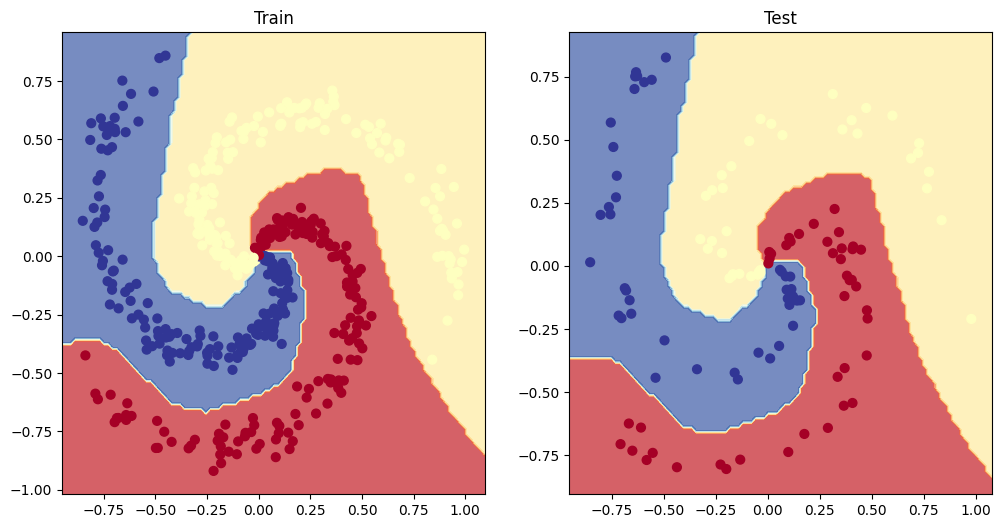

In [806]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_ex7, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_ex7, X_test, y_test)